In [ ]:



# For viewing and manipulating data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Importing the necessary libraries
import re
import math
import string
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gensim.downloader as api
from gensim.models import KeyedVectors # >> alternative to gensim.downloader
import matplotlib.pyplot as plt

# Getting particular functions from these libraries 
from torch import Tensor
from sklearn.utils import resample
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import random_split, DataLoader, TensorDataset, Dataset

# Using the NLTK to tokenize the text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
reviews_file = ''
w2v_file = ''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_name = os.path.join(dirname, filename)
        if file_name.endswith('.csv'): 
            reviews_file = file_name
        elif file_name.endswith('.bin'):
            w2v_file = file_name
        else:
            print(f'Found unexpected file: {file_name}')
                
print(f'Amazon reviews file: {reviews_file}')
print(f'Google news word to vec file: {w2v_file}') #<< faster than doing api.load
            

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
VERBOSE = True
def printv(text):
    if VERBOSE: print('VERBOSE:', text)
    return

def showV(text):
    '''unconditional verbose output'''
    print('VERBOSE:', text)
    return

DEV = True
def printd(text):
    if DEV: print('DEV:', text)
    return

def showD(text):
    '''unconditional DEV output'''
    print('VERBOSE:', text)
    return

showCellCompletion = False
def showC(text):
    if showCellCompletion:
        print('Cell complete:', text)
    return

import subprocess
showNv = True
accelerator = True

def printNv():
    if not showNv or not accelerator: return
    mem_usage = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(mem_usage.stdout.decode('utf-8'))

showMemoryAllocation = True
def printM():
    if not showMemoryAllocation: return
    print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")

In [2]:
## Only run once
#>> Seems to need to be rerun after every Kaggle timeout.
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [3]:
# Load data from CSV
#>>  3/13 needed to change the path as below
# path ='/kaggle/input/Reviews.csv'#"/kaggle/input/amazon-product-reviews/Reviews.csv"
data = pd.read_csv(reviews_file) # Use pandas to analyze data
showD('Amazon reviews loaded into Panda')

VERBOSE: Amazon reviews loaded into Panda


In [4]:
# print number of rows in our ratings column
printv(f'Number of reviews: {len(data["Score"])}')
printv(f'Column names -\n {data.columns}\n') 
printv(f'First five rows -\n{data.head()}')

VERBOSE: Number of reviews: 568454
VERBOSE: Column names -
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

VERBOSE: First five rows -
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                     

In [5]:
# Check for empty entries or missing data in each column
for column in data.columns:
    if data[column].isnull().values.any():
        print(f"Column '{column}' has empty entries or missing data.")
    else:
        print(f"Column '{column}' has no empty entries or missing data.")

Column 'Id' has no empty entries or missing data.
Column 'ProductId' has no empty entries or missing data.
Column 'UserId' has no empty entries or missing data.
Column 'ProfileName' has empty entries or missing data.
Column 'HelpfulnessNumerator' has no empty entries or missing data.
Column 'HelpfulnessDenominator' has no empty entries or missing data.
Column 'Score' has no empty entries or missing data.
Column 'Time' has no empty entries or missing data.
Column 'Summary' has empty entries or missing data.
Column 'Text' has no empty entries or missing data.


52,268 samples from balanced data with rating 1

29,769 samples from balanced data with rating 2

42,640 samples from balanced data with rating 3

80,655 samples from balanced data with rating 4

363,122 samples from balanced data with rating 5


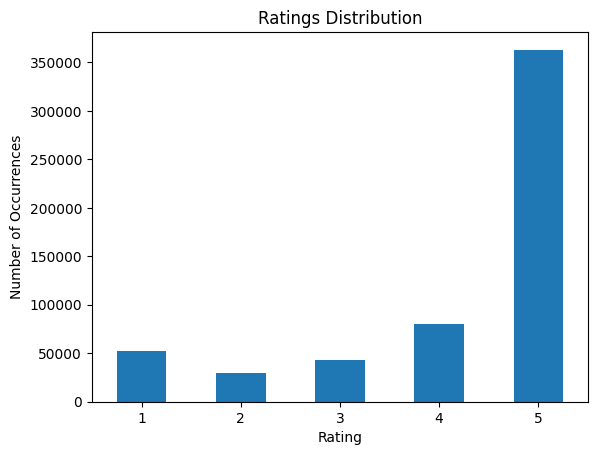

In [6]:
# Get count of ratings 
rating_counts = data['Score'].value_counts()

# Sort counts by index ascending
rating_counts = rating_counts.sort_index()  

# Create bar plot
ax = rating_counts.plot(kind = 'bar')

ax.set_title("Ratings Distribution")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Occurrences")

# Fix x-axis tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0) 

for rating, count in rating_counts.items():
        print(f"{count:,} samples from balanced data with rating {rating}\n")

plt.show() #<< show the rating in each of the 5 categories      

In [7]:
balanced_data_size = 10000 #25000<< number of reviews in each rating category, tailored for CPU capacity
# Specify the column for sorting and balancing
sort_column = 'Score'  # This is one the rating column

# Sort the data by the rating values
sorted_data = data.sort_values(by = sort_column)

# Create a balanced dataset with 25,000 samples from each class
#balanced_data = sorted_data.groupby(sort_column).apply(lambda x: x.sample(n=25000))

#>> DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. 
#>> This behavior is deprecated, and in a future version of pandas the grouping 
#>> columns will be excluded from the operation. 
#>> Either pass `include_groups=False` to exclude the groupings or 
#>> explicitly select the grouping columns after groupby to silence this warning.
#
balanced_data = sorted_data.groupby(sort_column).apply(lambda x: x.sample(n = balanced_data_size))

#>> Does this mean to reset the row numbers?? ##Columns Numbers
balanced_data.reset_index(drop = True, inplace = True)

printv(f"The number of reviews equally distributed across all ratings is {len(balanced_data['Score'])}")

VERBOSE: The number of reviews equally distributed across all ratings is 50000


/tmp/ipykernel_26/2242767158.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = sorted_data.groupby(sort_column).apply(lambda x: x.sample(n = balanced_data_size))


10,000 samples from balanced data with rating 1

10,000 samples from balanced data with rating 2

10,000 samples from balanced data with rating 3

10,000 samples from balanced data with rating 4

10,000 samples from balanced data with rating 5


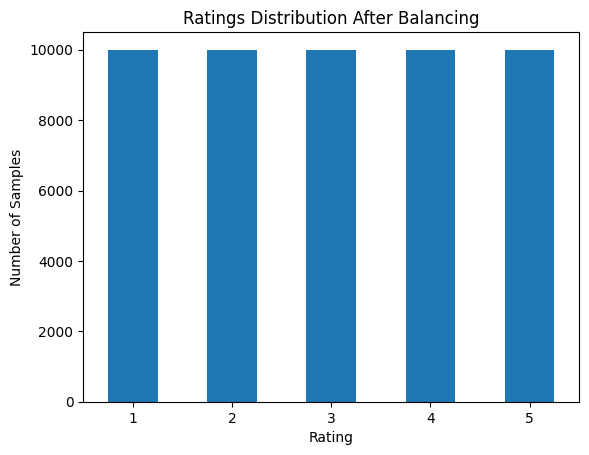

In [8]:
# Get count of ratings
rating_counts = balanced_data['Score'].value_counts()

# Create bar plot
ax = rating_counts.plot(kind='bar')

ax.set_title("Ratings Distribution After Balancing")
ax.set_xlabel("Rating")
ax.set_ylabel("Number of Samples")

# Fix x-axis ticks  
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)

# Print number of reviews per rating

if DEV:
    for rating, count in rating_counts.items():
        print(f"{count:,} samples from balanced data with rating {rating}\n")

plt.show()

In [9]:
import spacy
import re
import pandas as pd

# Load the English tokenizer model
nlp = spacy.load("en_core_web_sm")

# Compile the regular expressions
html_tags = re.compile("<.*?>")
punct_and_symbols = re.compile(r'[^\w\s\']+')

def tokenizer(text, nlp):
    """
    Tokenizes a text string and removes stop words.
    
    text (str): The text string to tokenize.
    nlp: The Spacy language model.

    Returns:
        list: The tokenized text string.
    """
    text = text.lower()  # Convert text to lowercase
    text = html_tags.sub("", text)  # Remove HTML tags
    text = punct_and_symbols.sub("", text)  # Remove punctuation and symbols

    # Tokenize the text
    doc = nlp(text)

    # Remove stop words and punctuation tokens
    # tokens = [token.text for token in doc if not token.is_punct]# and not token.is_stop]
    #>> Do we have any control over the stop words
    tokens = [token.text for token in doc if not token.is_punct and not token.is_stop]

    return tokens

# Assuming balanced_data is a pandas DataFrame and 'Text' is a column containing the reviews
# Apply the function to the Text column and store it in a new column
balanced_data['CleanedReview'] = balanced_data['Text'].apply(lambda x: tokenizer(x, nlp))

# Show that cell has finished executing
showC(f'{tokenizer} defined, and then used to create CleanedReview column')

In [10]:
# Store the Rating column
rating = balanced_data['Score']  

# Store the CleanedReview column
tokenized_review = balanced_data['CleanedReview']
showD(f'specify the columns that will be used to train the classifier')

printv(f"First balanced data review: {balanced_data['Text'][0]}")
printv(f"First balanced data tokenized review: {tokenized_review[0]}")
printv(f"First balanced data tokenized review length: {tokenized_review[0]}")
printv(f"tokenized_review shape: {tokenized_review.shape}")

VERBOSE: specify the columns that will be used to train the classifier
Bed, Bath and Beyond has this coffee in the store and on their website for half the price offered here. 

['bed', 'bath', 'coffee', 'store', 'website', 'half', 'price', 'offered'] 

8 

(50000,)


Mean: 40.02
Median: 28.00
Mode: ModeResult(mode=12, count=1481)


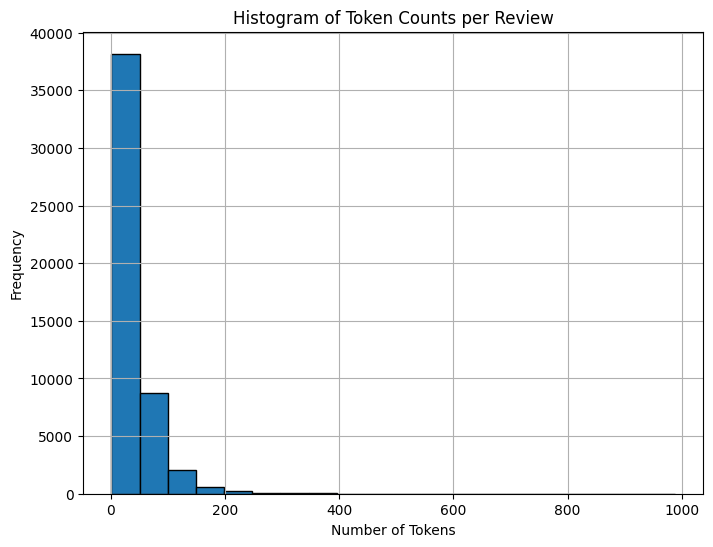

In [11]:
from scipy import stats

def analyze_review_tokens(reviews):
    token_counts = [len(review) for review in reviews]

    mean = np.mean(token_counts)
    median = np.median(token_counts)
    mode = stats.mode(token_counts)

    print(f"Mean: {mean:.2f}")
    print(f"Median: {median:.2f}")
    print(f"Mode: {mode}")

    plt.figure(figsize=(8, 6))
    plt.hist(token_counts, bins=20, edgecolor='black')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.title('Histogram of Token Counts per Review')
    plt.grid(True)
    plt.show()

analyze_review_tokens(tokenized_review)

In [12]:
# >> 3/29/24 Took less than a minute to run without the accelerator.
# Load Word2Vec model
#w2v = api.load('word2vec-google-news-300')
w2v = KeyedVectors.load_word2vec_format (w2v_file, binary=True)

# Define the aimum sequence length (adjust as needed)
#>> Will increasing max_sequence_length impact performance?
max_sequence_length = 100

showD(f'{w2v} can map words onto vectors with 300 dimensions')

VERBOSE: KeyedVectors<vector_size=300, 3000000 keys> can map words onto vectors with 300 dimensions


In [13]:
# Checks if a CUDA enabled GPU is available and prints out its information
if torch.cuda.is_available():
    print("CUDA is available!")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        
    device = torch.device("cuda:0")
    accelerator = True

else:
    accelerator = False
    print("CUDA is not available.")
    device = torch.device("cpu")
    print(device)

CUDA is available!
GPU 0: Tesla P100-PCIE-16GB


In [14]:
#>> 3/29/24 Completed in less than 30 seconds using 1347 as max_sequence_length 

# Assume you have a list of tokenized review called tokenized_review
# Each element in tokenized_review is a list of tokens for a single review

lengths = []
for review_tokens in tokenized_review:
    lengths.append(len(review_tokens))

lengths = sorted(lengths)
lengths = lengths[-1:0:-1]
showD(f'Lengths of 100 longest reviews: {lengths[0:100]}')        

max_sequence_length = 100 #<< 3/29/24 1347 was the longest review length in sample

# Initialize an empty tensor for padded reviews on the GPU
padded_reviews = torch.zeros((len(tokenized_review), max_sequence_length, 300))

# Initialize a mask tensor of the same shape as padded_reviews
# Set it to False (or 0) initially, representing that all positions are padding
# mask = torch.zeros_like(padded_reviews, dtype=torch.bool)

# Initialize a mask tensor of the same shape as padded_reviews but with only sequence length
mask = torch.zeros((len(tokenized_review), max_sequence_length), dtype=torch.bool)

out_words = {}
words_in = 0
words_out = 0

# Now, during the padding and embedding conversion loop, update the mask as well
for i, review_tokens in enumerate(tokenized_review):
    review_length = min(len(review_tokens), max_sequence_length)
    for j in range(review_length):
        word = review_tokens[j]
        if word in w2v:
            words_in += 1
            # Use Word2Vec vector if available
            padded_reviews[i, j, :] = torch.tensor(w2v[word])
            mask[i, j] = True  # Update the mask to indicate the presence of a word
        else:
            words_out += 1
            out_words[word] = out_words.get(word, 0) + 1
        # Otherwise, the mask remains False (or 0) for padding

# Now you have a mask tensor that you can use later in your processing to ignore padded values
# For example, if you want to apply max pooling only on non-padded values, you could use:
# review_embeddings = torch.max(padded_reviews * mask.unsqueeze(-1).float(), dim=1)[0]

# Ensure the mask is treated as a float for any operations that require it
mask = mask.float()

# Now you can use this mask tensor to exclude the padding from any subsequent computations

printv(f'{words_in} words found with vector representations, {words_out} without')
printv(f'Number of unique words without vector representations: {len(out_words)}')
printd('Sample of words without vector representations')
kwords = list(out_words.keys())
for idx in range(0,len(kwords)-1,100):
    kword = kwords[idx]
    printd(f'{kword} - {out_words[kword]}')
# Apply max pooling to aggregate embeddings along the sequence dimension
# review_embeddings = torch.max(padded_reviews, dim=1)[0]

# Now,review_embeddings contains the aggregated Word2Vec 
# embeddings for each review on the GPU

showC(f"Created zero-padded, standard length reviews")

VERBOSE: Lengths of 100 longest reviews: [988, 725, 722, 701, 666, 648, 615, 560, 557, 557, 553, 540, 518, 490, 485, 484, 476, 470, 460, 437, 433, 430, 430, 429, 415, 411, 408, 408, 407, 405, 396, 396, 396, 396, 387, 387, 383, 381, 380, 379, 375, 370, 366, 366, 365, 364, 364, 362, 362, 359, 357, 357, 356, 356, 354, 349, 349, 349, 348, 345, 344, 343, 342, 341, 339, 339, 338, 338, 337, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336]
VERBOSE: 1631073 words found with vector representations, 203355 without
VERBOSE: Number of unique words without vector representations: 44083
DEV: Sample of words without vector representations
DEV: 32 - 119
DEV: shakercup - 2
DEV: mummums - 2
DEV: twentyfour - 8
DEV: excelenciai - 1
DEV: betteri - 29
DEV: oldwhat - 2
DEV: backwent - 2
DEV: wondersfor - 1
DEV: schar - 20
DEV: againwow - 1
DEV: fromsince - 1
DEV: asdiamond - 2
DEV: airalso - 1
DEV: seasa

In [15]:
print(padded_reviews[1])

tensor([[-0.0615,  0.0952,  0.1338,  ...,  0.1396,  0.0297,  0.0008],
        [ 0.0898,  0.0103, -0.2246,  ..., -0.0618,  0.1924,  0.1060],
        [-0.0294,  0.1177, -0.1504,  ...,  0.0608, -0.0737, -0.0199],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [16]:
#>> padded_reviews are 100 x 300 tensors, zero padded if necessary
#>> to get the standard lenth
text_embeddings_tensors = padded_reviews.to(device)

# Rating labels
rating_labels_tensors = torch.tensor(rating.values).to(device)

# Dataset
dataset = TensorDataset(text_embeddings_tensors, rating_labels_tensors)
showC(f'{dataset} defined')

printM() # print(f"Total allocated memory: {torch.cuda.memory_allocated()} bytes")
printNv() #!nvidia-smi
print('\n\n\n\n\n\n\n\n\n\n')
if accelerator and showNv:
    print(torch.cuda.memory_summary())

Total allocated memory: 6000400384 bytes
Sun Apr  7 06:22:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              32W / 250W |   5982MiB / 16384MiB |     40%      Default |
|                                         |                      |                  N/A |
+--------------------------

Dataset with missing reviews - done

Improved tokenizer - done

Mask 0-padded values in embedding tensor - done 

Max sequence of 1300. Max length of 500?

Encoder dropout to 0

Review token histogram for sequence length - done 

In [17]:
#>> padded_reviews are 100 x 300 tensors, zero padded if necessary
#>> to get the standard lenth
text_embeddings_tensors = padded_reviews.to(device)

# Rating labels
rating_labels_tensors = torch.tensor(rating.values).to(device)

# Dataset
dataset = TensorDataset(text_embeddings_tensors, rating_labels_tensors)
showC(f'{dataset} defined')

In [18]:
print(text_embeddings_tensors.shape)
print(rating_labels_tensors.shape)
print(text_embeddings_tensors.device)
print(rating_labels_tensors.device)
print(dataset)

torch.Size([50000, 100, 300])
torch.Size([50000])
cuda:0
cuda:0


In [19]:
# Lengths 
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len

# Random split
train_data, val_data = random_split(dataset, [train_len, val_len])

printv(f"The amount of data we have to train with is {len(train_data)} revieww") 
printv(f"The amount of data we have to validate with is {len(val_data)} reviews")
#print(f"The amount of data we have to validate with is on {train_data.device}")
#print(f"The amount of data we have to validate with is on {val_data.device}")

# DataLoader for training data
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)  # Use shuffle for training

# DataLoader for validation data
val_loader = DataLoader(val_data, batch_size = 32, shuffle = False)  # No need to shuffle for validation

VERBOSE: The amount of data we have to train with is 40000 revieww
VERBOSE: The amount of data we have to validate with is 10000 reviews


In [20]:
# HyperParameters for the module
d_model = 300  # Should match the embedding dimension of your word embeddings
seq_len = 100  # Maximum sequence length
dropout = 0.1  # Adjust the dropout if needed

eps     = 1e-6 # epsilon value to prevent the standard deviation from becoming zero
num_classes = 5  # Replace with your number of classes
epochs = 1000
learning_rate = 0.01
num_layers = 6

input_size = d_model  # Adjust this based on the output size of your feed-forward network
# input_size = len(train_data[0])  # Adjust based on your input size (should match the output size of your model)
showC('Hyperparameters defined')

In [21]:
class Classifier(nn.Module):
    def __init__(self, r_size,v_size, num_classes):
        # r_size is the number of tokens in a review, 100.
        # v_size is the number of values in an embedding vector, 300.
        super(Classifier, self).__init__()
        
        # The input to fc will be a 2D tensor with with n rows and
        # r_size * v_size columns, where n >= 1; and the output will be a 2D tensor
        # with n rows and num_classes columns.
        self.fc = nn.Linear(r_size * v_size, num_classes)

    def forward(self, x1):
        # Pass input through the linear layer
        return self.fc(x1)

# Create the classifier
classifier = Classifier(seq_len, d_model, num_classes + 1).to(device)

showC(f'{Classifier} defined')

In [22]:
# Define Cross-Entropy loss
criterion = nn.CrossEntropyLoss() # nn.CategoricalCrossentropy() #nn.Softmax() 

# Define SGD optimizer
# Is Adam better?
optimizer = optim.SGD(classifier.parameters(), lr=learning_rate)

DEV = True
# Training loop (adjust this to match your data and DataLoader)
for epoch in range(epochs):
    for inputs, targets in train_loader :  # Assuming you have a DataLoader
        # for batch_data in train_loader:  # Assuming you have a DataLoader
        # inputs, targets = batch_data  # Assuming your DataLoader provides input data and targets    
    
        #printd(f'inputs shape: {inputs.shape}')
        #printd(f'targets shape: {targets.shape}')
        #printd(f'targets: {targets}')

        optimizer.zero_grad()
    
        # keep nn.linear happy by combining the last two dimensions of inputs.
        inputs = torch.reshape(inputs, (inputs.size(0), -1)) # get current batch size
        #inputs = torch.reshape(inputs, (32,30000))
        
        #printd(f'Reshaped inputs: {inputs.shape}')
        
        outputs = classifier(inputs)
        #printd(f'outputs shape {outputs.shape}')
        
        # output is a 32 x 6 tensor of floats,
        # targets will be a 32 x 1 tensor of ints
        loss = criterion(outputs, targets)
        # print(f'loss.item: {loss.item()}')
        loss.backward(retain_graph=True)
        optimizer.step()
     
    print(f'Epoch [{epoch+1}/{epochs}] Loss: {loss.item()}')
    
showC(f'training complete')

Epoch [1/1000] Loss: 1.4198670387268066
Epoch [2/1000] Loss: 1.4484740495681763
Epoch [3/1000] Loss: 1.1991708278656006
Epoch [4/1000] Loss: 1.325643539428711
Epoch [5/1000] Loss: 1.3421779870986938
Epoch [6/1000] Loss: 1.171980857849121
Epoch [7/1000] Loss: 1.1598052978515625
Epoch [8/1000] Loss: 1.0601404905319214
Epoch [9/1000] Loss: 1.2424856424331665
Epoch [10/1000] Loss: 0.9439870119094849
Epoch [11/1000] Loss: 1.0500956773757935
Epoch [12/1000] Loss: 1.1612168550491333
Epoch [13/1000] Loss: 0.8931447863578796
Epoch [14/1000] Loss: 1.0650930404663086
Epoch [15/1000] Loss: 0.8772878646850586
Epoch [16/1000] Loss: 0.9902452230453491
Epoch [17/1000] Loss: 0.8986594676971436
Epoch [18/1000] Loss: 0.8876699805259705
Epoch [19/1000] Loss: 0.8358867168426514
Epoch [20/1000] Loss: 1.0665656328201294
Epoch [21/1000] Loss: 1.2108774185180664
Epoch [22/1000] Loss: 0.8750879168510437
Epoch [23/1000] Loss: 0.7426676750183105
Epoch [24/1000] Loss: 0.8310621976852417
Epoch [25/1000] Loss: 0.748

In [23]:
# Put model in evaluation mode
classifier.eval() 

# Tracking variables
predictions = []
actuals = []

# Evaluate on validation set
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.reshape(inputs.shape[0], -1)

        outputs = classifier(inputs)
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.tolist())
        actuals.extend(targets.tolist())

# Print predicted and actual values for all samples
print("Predicted | Actual")
for pred, actual in zip(predictions, actuals):
    print(f"{pred} | {actual}")

# Calculate validation accuracy
num_correct = sum([p == a for p, a in zip(predictions, actuals)]) 
val_accuracy = num_correct / len(predictions)
print(f'Validation Accuracy: {val_accuracy:.2f}')

Predicted | Actual
2 | 4
5 | 1
3 | 1
2 | 3
3 | 4
3 | 4
5 | 5
4 | 4
1 | 3
3 | 4
1 | 1
3 | 3
1 | 2
5 | 2
3 | 3
2 | 2
1 | 1
4 | 3
4 | 4
4 | 4
1 | 1
3 | 1
4 | 4
4 | 5
2 | 3
4 | 4
5 | 2
4 | 4
4 | 4
3 | 3
4 | 3
4 | 5
3 | 3
4 | 4
5 | 4
2 | 1
5 | 5
1 | 3
5 | 5
3 | 3
4 | 4
5 | 3
2 | 4
3 | 4
5 | 4
5 | 4
2 | 2
2 | 4
2 | 3
1 | 1
1 | 3
2 | 5
5 | 4
5 | 5
2 | 2
2 | 2
2 | 2
4 | 4
1 | 3
3 | 4
2 | 2
3 | 2
5 | 5
3 | 3
5 | 1
1 | 3
4 | 1
4 | 4
2 | 2
5 | 4
3 | 4
5 | 5
3 | 4
2 | 2
2 | 2
3 | 3
4 | 4
2 | 2
2 | 4
5 | 5
1 | 1
1 | 4
1 | 1
1 | 1
4 | 4
2 | 2
4 | 4
4 | 5
2 | 3
2 | 2
2 | 4
4 | 4
5 | 5
2 | 2
3 | 1
3 | 4
4 | 2
5 | 3
4 | 4
1 | 1
5 | 4
1 | 1
5 | 4
3 | 2
5 | 5
2 | 2
2 | 2
1 | 3
3 | 4
1 | 1
2 | 2
5 | 3
3 | 1
4 | 5
2 | 4
4 | 4
3 | 3
2 | 3
4 | 4
5 | 5
1 | 4
3 | 4
2 | 1
3 | 4
4 | 3
2 | 2
4 | 5
5 | 5
4 | 5
1 | 3
4 | 4
3 | 3
1 | 5
2 | 1
5 | 1
1 | 1
5 | 1
5 | 4
1 | 3
3 | 4
3 | 5
5 | 5
1 | 1
4 | 3
4 | 4
1 | 1
4 | 4
2 | 2
3 | 5
3 | 2
4 | 3
3 | 3
2 | 4
5 | 3
3 | 5
2 | 3
1 | 1
4 | 2
4 | 4
5 | 5
1 | 2
1 | 3
3 | 2
1 |